In [1]:
import os, sys
sys.path.insert(0, os.path.dirname(os.getcwd())) 

In [2]:
import cache_magic
import hashlib
from typing import List, Union, Dict, Any
from tqdm import tqdm
import pandas as pd
import numpy as np
import multiprocessing
from concurrent.futures import ProcessPoolExecutor

from xgboost import XGBRegressor
import lightgbm as lgbm

from ml_trader.utils import load_config
from ml_trader.data_loaders.quandl import (quandl_base_to_df,
                                           quandl_quarterly_to_df,
                                           quandl_daily_to_df,
                                           quandl_commodity_to_df)
from ml_trader.model import LogExpModel, EnsembleModel
from ml_trader.features import (MAX_BACK_QUARTER,
                                MIN_BACK_QUARTER,
                                QUARTER_WINDOWS,
                                QUARTER_COLUMNS,
                                DAILY_WINDOWS,
                                DAILY_AGG_COLUMNS,
                                compute_df_quarterly_ticker,
                                compute_df_daily_ticker,
                                compute_df_commodity_ticker)

%cache magic is now registered in ipython


In [3]:
CPU_COUNT = multiprocessing.cpu_count()
CPU_COUNT

8

In [4]:
# %cache --reset

In [5]:
config = load_config()
TICKERS = config["tickers"]
COMMODITIES = config["commodities"]
len(TICKERS), TICKERS[:10]

(1492,
 ['ZI', 'HALO', 'WGO', 'VIPS', 'OSK', 'MAC', 'BJRI', 'HCCI', 'HSC', 'ANAB'])

## Base Features

In [6]:
df_base = quandl_base_to_df(
    filepath=os.path.dirname(os.getcwd()) + '/datasets/quandl/SHARADAR_TICKERS_6cc728d11002ab9cb99aa8654a6b9f4e.csv',
    tickers=TICKERS,
)
df_base.head()

,table,permaticker,ticker,name,exchange,isdelisted,category,cusips,siccode,sicsector,...,currency,location,lastupdated,firstadded,firstpricedate,lastpricedate,firstquarter,lastquarter,secfilings,companysite
0,SF1,196290,A,Agilent Technologies Inc,NYSE,N,Domestic Common Stock,00846U101,3826.0,Manufacturing,...,USD,California; U.S.A,2021-06-01,2014-09-26,1999-11-18,2021-07-21,1997-06-30,2021-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.agilent.com
1,SF1,124392,AA,Alcoa Corp,NYSE,N,Domestic Common Stock,013872106,3334.0,Manufacturing,...,USD,Pennsylvania; U.S.A,2021-05-05,2016-11-01,2016-11-01,2021-07-21,2014-12-31,2021-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.alcoa.com
2,SF1,199960,AAL,American Airlines Group Inc,NASDAQ,N,Domestic Common Stock,02376R102,4512.0,Transportation Communications Electric Gas And...,...,USD,Texas; U.S.A,2021-04-22,2015-04-14,2013-12-09,2021-07-21,2012-12-31,2021-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.aa.com
3,SF1,632687,AAN,Aaron's Company Inc,NYSE,N,Domestic Common Stock,00258W108,7359.0,Services,...,USD,Georgia; U.S.A,2021-05-02,2020-12-02,2020-11-25,2021-07-21,2018-12-31,2021-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN
4,SF1,198259,AAON,Aaon Inc,NASDAQ,N,Domestic Common Stock,000360206,3585.0,Manufacturing,...,USD,Oklahoma; U.S.A,2021-05-06,2014-10-14,1992-12-16,2021-07-21,1996-12-31,2021-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.aaon.com


In [7]:
def int_hash_of_str(text: str) -> int:
    return int(hashlib.md5(text.encode('utf-8')).hexdigest()[:8], 16)

int_hash_of_str('Some text')

2645911594

In [8]:
class RobustHashingEncoder:
    def transform(self, vals: List[str]):
        result = [int_hash_of_str(str(x)) for x in vals]
        return result

RobustHashingEncoder().transform(['hey', 'John'])

[1616376124, 1631623841]

In [9]:
len(df_base['sector'].unique())

11

In [10]:
len(df_base['sicindustry'].unique())

307

In [11]:
for col in ['sector', 'sicindustry']:
    df_base[col] = df_base[col].fillna('None')
    df_base[col] = RobustHashingEncoder().transform(df_base[col])

df_base_p = df_base[['ticker', 'sector', 'sicindustry']]
df_base_p = df_base_p.set_index(['ticker'])
df_base_p

,sector,sicindustry
ticker,,
A,1323476679,262192036
AA,3574770013,3133277726
AAL,4234451709,970993397
AAN,2619316219,3235711193
AAON,3574770013,1976331230
...,...,...
ZUMZ,2619316219,3693376755
ZUO,3890702295,3522964152
ZY,3574770013,491461314


## Quarterly Features

In [12]:
df_quarterly = quandl_quarterly_to_df(
    base_path=os.path.dirname(os.getcwd()) + '/datasets/quandl/quarterly',
    tickers=TICKERS,
)
df_quarterly = df_quarterly.sort_values(by=['ticker', 'date'], ascending=False)
df_quarterly.head()

,ticker,dimension,calendardate,reportperiod,lastupdated,accoci,assets,assetsavg,assetsc,assetsnc,...,shareswa,shareswadil,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital,date
8993,ZYXI,ARQ,2021-03-31,2021-03-31,2021-04-30,0.0,70236000.0,NaN,60829000.0,9407000.0,...,34837000.0,34837000.0,0.693,70236000.0,931000.0,-384000.0,266000.0,2.016,51514000.0,2021-04-29
8994,ZYXI,ARQ,2020-12-31,2020-12-31,2021-04-30,0.0,72175000.0,NaN,63023000.0,9152000.0,...,34784000.0,35627000.0,0.736,72175000.0,566000.0,428000.0,280000.0,2.075,52906000.0,2021-02-25
8995,ZYXI,ARQ,2020-09-30,2020-09-30,2021-04-30,0.0,64965000.0,NaN,57553000.0,7412000.0,...,34486000.0,35476000.0,0.581,64965000.0,985000.0,71000.0,429000.0,1.884,50258000.0,2020-10-27
8996,ZYXI,ARQ,2020-06-30,2020-06-30,2021-04-30,0.0,36759000.0,NaN,29833000.0,6926000.0,...,33283000.0,34454000.0,0.579,36759000.0,545000.0,1063000.0,0.0,1.104,23813000.0,2020-07-28
8997,ZYXI,ARQ,2020-03-31,2020-03-31,2021-04-30,0.0,33222000.0,NaN,25698000.0,7524000.0,...,32913000.0,34204000.0,0.463,33222000.0,985000.0,-483000.0,39000.0,1.009,19864000.0,2020-04-28


In [13]:
ticker = 'AAPL'

In [14]:
quarterly_data = df_quarterly[df_quarterly['ticker'] == ticker]
quarterly_data.head()

,ticker,dimension,calendardate,reportperiod,lastupdated,accoci,assets,assetsavg,assetsc,assetsnc,...,shareswa,shareswadil,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital,date
5210,AAPL,ARQ,2021-03-31,2021-03-27,2021-04-29,-2.860000e+08,3.371580e+11,NaN,1.214650e+11,2.156930e+11,...,1.675348e+10,1.692916e+10,5.347,3.371580e+11,0.0,4.381000e+09,0.0,20.125,1.508000e+10,2021-04-29
5211,AAPL,ARQ,2020-12-31,2020-12-26,2021-04-29,1.790000e+08,3.540540e+11,NaN,1.541060e+11,1.999480e+11,...,1.693512e+10,1.711369e+10,6.580,3.540540e+11,0.0,4.824000e+09,0.0,20.906,2.159900e+10,2021-01-28
5212,AAPL,ARQ,2020-09-30,2020-09-26,2021-04-29,-4.060000e+08,3.238880e+11,NaN,1.437130e+11,1.801750e+11,...,1.705762e+10,1.725652e+10,3.793,3.238880e+11,0.0,2.228000e+09,0.0,18.988,3.832100e+10,2020-10-30
5213,AAPL,ARQ,2020-06-30,2020-06-27,2021-04-29,-5.500000e+08,3.173440e+11,NaN,1.400650e+11,1.772790e+11,...,1.725029e+10,1.741915e+10,3.460,3.173440e+11,0.0,1.884000e+09,0.0,18.396,4.474700e+10,2020-07-31
5214,AAPL,ARQ,2020-03-31,2020-03-28,2021-04-29,-2.789000e+09,3.204000e+11,NaN,1.437530e+11,1.766470e+11,...,1.744040e+10,1.761876e+10,3.344,3.204000e+11,0.0,1.886000e+09,0.0,18.371,4.765900e+10,2020-05-01


In [15]:
quarterly_data.shape

(21, 111)

### Series features for last quarter

In [16]:
quarterly_data[QUARTER_COLUMNS].head()

,revenue,netinc,ncf,assets,ebitda,debt,fcf,gp,workingcapital,cashneq,rnd,sgna,ncfx,divyield,currentratio,netinccmn
5210,8.958400e+10,2.363000e+10,2.287000e+09,3.371580e+11,3.080800e+10,1.216450e+11,2.171200e+10,3.807900e+10,1.508000e+10,3.846600e+10,5.262000e+09,5.314000e+09,0.0,0.006,1.142,2.363000e+10
5211,1.114390e+11,2.875500e+10,-2.070000e+09,3.540540e+11,3.624500e+10,1.120430e+11,3.526300e+10,4.432800e+10,2.159900e+10,3.601000e+10,5.163000e+09,5.631000e+09,0.0,0.006,1.163,2.875500e+10
5212,6.469800e+10,1.267300e+10,4.750000e+09,3.238880e+11,1.760300e+10,1.124360e+11,1.879200e+10,2.468900e+10,3.832100e+10,3.801600e+10,4.978000e+09,4.936000e+09,0.0,0.007,1.364,1.267300e+10
5213,5.968500e+10,1.125300e+10,-8.010000e+09,3.173440e+11,1.588900e+10,1.127230e+11,1.470600e+10,2.268000e+10,4.474700e+10,3.338300e+10,4.758000e+09,4.831000e+09,0.0,0.007,1.469,1.125300e+10
5214,5.831300e+10,1.124900e+10,1.384000e+09,3.204000e+11,1.592100e+10,1.095070e+11,1.145800e+10,2.237000e+10,4.765900e+10,4.017400e+10,4.565000e+09,4.952000e+09,0.0,0.011,1.496,1.124900e+10


In [17]:
col = 'revenue'
quarter_cnt = 4

In [18]:
# Revenue for past 2 quarters
series = quarterly_data[col].values[:quarter_cnt][::-1].astype('float')
series

array([5.96850e+10, 6.46980e+10, 1.11439e+11, 8.95840e+10])

In [19]:
series = np.array(series).astype('float')
series

array([5.96850e+10, 6.46980e+10, 1.11439e+11, 8.95840e+10])

In [20]:
series = series[~np.isnan(series)]
series

array([5.96850e+10, 6.46980e+10, 1.11439e+11, 8.95840e+10])

In [21]:
name_prefix = f'quarter_{col}_{quarter_cnt}'
stats = {
    f'{name_prefix}_mean': np.mean(series),
    f'{name_prefix}_median': np.median(series),
    f'{name_prefix}_max': np.max(series),
    f'{name_prefix}_min': np.min(series),
    f'{name_prefix}_std': np.std(series),
}
stats

{'quarter_revenue_4_mean': 81351500000.0,
 'quarter_revenue_4_median': 77141000000.0,
 'quarter_revenue_4_max': 111439000000.0,
 'quarter_revenue_4_min': 59685000000.0,
 'quarter_revenue_4_std': 20735283920.16854}

In [22]:
np.diff(series)

array([ 5.0130e+09,  4.6741e+10, -2.1855e+10])

### Series features for each quarter in the past

In [23]:
# Window features for each ticker & each quarter

def compute_df_quarterly_p() -> pd.DataFrame:
    with ProcessPoolExecutor(max_workers=CPU_COUNT) as executor:
        with tqdm(total=len(TICKERS), mininterval=2) as progress:
            futures = []
            for ticker in TICKERS:
                f = executor.submit(
                    compute_df_quarterly_ticker,
                    df_quarterly_ticker=df_quarterly[df_quarterly['ticker'] == ticker],
                    ticker=ticker,
                )
                f.add_done_callback(lambda p: progress.update())
                futures.append(f)

            result: List[Dict[str, Any]] = []
            for f in futures:
                result += f.result()

    # Dont set_index here to merge it with base_features later
    df_quarterly_p = pd.DataFrame(result)
    return df_quarterly_p

In [24]:
%cache df_quarterly_p = compute_df_quarterly_p()

loading cached value for variable 'df_quarterly_p'. Time since pickling  0:22:57.101504


In [25]:
df_quarterly_p

,ticker,date,quarter_series_2_revenue_mean,quarter_series_2_revenue_median,quarter_series_2_revenue_max,quarter_series_2_revenue_min,quarter_series_2_revenue_std,quarter_diffs_2_revenue_mean,quarter_diffs_2_revenue_median,quarter_diffs_2_revenue_max,...,quarter_series_10_netinccmn_mean,quarter_series_10_netinccmn_median,quarter_series_10_netinccmn_max,quarter_series_10_netinccmn_min,quarter_series_10_netinccmn_std,quarter_diffs_10_netinccmn_mean,quarter_diffs_10_netinccmn_median,quarter_diffs_10_netinccmn_max,quarter_diffs_10_netinccmn_min,quarter_diffs_10_netinccmn_std
0,ZI,2021-05-03,146500000.0,146500000.0,153300000.0,139700000.0,6800000.0,13600000.0,13600000.0,13600000.0,...,-1.171429e+06,3200000.0,25500000.0,-20400000.0,1.495725e+07,1.516667e+06,0.0,25300000.0,-22300000.0,1.711816e+07
1,ZI,2021-02-26,131550000.0,131550000.0,139700000.0,123400000.0,8150000.0,16300000.0,16300000.0,16300000.0,...,-1.900000e+06,-500000.0,25500000.0,-20400000.0,1.604026e+07,6.280000e+06,0.0,25300000.0,-14500000.0,1.467997e+07
2,ZI,2020-11-30,123400000.0,123400000.0,123400000.0,123400000.0,0.0,0.0,0.0,0.0,...,-7.380000e+06,-5900000.0,4900000.0,-20400000.0,1.133868e+07,2.700000e+06,0.0,25300000.0,-14500000.0,1.432812e+07
3,ZI,2020-11-13,117150000.0,117150000.0,123400000.0,110900000.0,6250000.0,12500000.0,12500000.0,12500000.0,...,-1.045000e+07,-13150000.0,4900000.0,-20400000.0,1.065751e+07,3.600000e+06,0.0,25300000.0,-14500000.0,1.644648e+07
4,ZI,2020-08-18,110900000.0,110900000.0,110900000.0,110900000.0,0.0,0.0,0.0,0.0,...,-1.556667e+07,-20400000.0,-5900000.0,-20400000.0,6.835366e+06,-7.250000e+06,-7250000.0,0.0,-14500000.0,7.250000e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27056,TXG,2020-11-12,57361000.0,57361000.0,71817000.0,42905000.0,14456000.0,28912000.0,28912000.0,28912000.0,...,-2.877900e+07,-21143000.0,-7134000.0,-65848000.0,2.190128e+07,-1.406125e+07,-16516500.0,2469000.0,-25681000.0,1.040312e+07
27057,TXG,2020-08-12,57405000.0,57405000.0,71905000.0,42905000.0,14500000.0,-29000000.0,-29000000.0,-29000000.0,...,-1.951175e+07,-15373000.0,-7134000.0,-40167000.0,1.304504e+07,-1.018800e+07,-14009000.0,2469000.0,-19024000.0,9.181042e+06
27058,TXG,2020-05-12,73597000.0,73597000.0,75289000.0,71905000.0,1692000.0,-3384000.0,-3384000.0,-3384000.0,...,-1.262667e+07,-9603000.0,-7134000.0,-21143000.0,6.105732e+06,-5.770000e+06,-5770000.0,2469000.0,-14009000.0,8.239000e+06
27059,TXG,2020-02-27,68248000.0,68248000.0,75289000.0,61207000.0,7041000.0,14082000.0,14082000.0,14082000.0,...,-8.368500e+06,-8368500.0,-7134000.0,-9603000.0,1.234500e+06,2.469000e+06,2469000.0,2469000.0,2469000.0,0.000000e+00


## Daily-based features 

In [26]:
df_daily = quandl_daily_to_df(
    base_path=os.path.dirname(os.getcwd()) + '/datasets/quandl/daily',
    tickers=TICKERS,
)
df_daily = df_daily.sort_values(by=['ticker', 'date'], ascending=False)
df_daily.head()

,ticker,date,lastupdated,ev,evebit,evebitda,marketcap,pb,pe,ps
599973,ZYXI,2021-07-20,2021-07-20,562.7,84.8,66.1,589600000.0,10.5,108.6,6.6
599974,ZYXI,2021-07-19,2021-07-19,549.5,82.8,64.6,576400000.0,10.3,106.1,6.5
599975,ZYXI,2021-07-16,2021-07-16,558.9,84.3,65.7,585800000.0,10.4,107.9,6.6
599976,ZYXI,2021-07-15,2021-07-15,502.4,75.7,59.1,529300000.0,9.4,97.5,5.9
599977,ZYXI,2021-07-14,2021-07-14,470.4,70.9,55.3,497300000.0,8.9,91.6,5.6


### Experiments

In [27]:
daily_data = df_daily[df_daily['ticker'] == ticker]
daily_data.head()

,ticker,date,lastupdated,ev,evebit,evebitda,marketcap,pb,pe,ps
346700,AAPL,2021-07-20,2021-07-20,2522076.3,28.1,25.1,2.438897e+12,35.3,32.0,7.5
346701,AAPL,2021-07-19,2021-07-19,2460332.0,27.5,24.5,2.377153e+12,34.4,31.2,7.3
346702,AAPL,2021-07-16,2021-07-16,2526081.3,28.2,25.1,2.442902e+12,35.3,32.0,7.5
346703,AAPL,2021-07-15,2021-07-15,2560958.5,28.6,25.5,2.477780e+12,35.8,32.5,7.6
346704,AAPL,2021-07-14,2021-07-14,2572139.2,28.7,25.6,2.488960e+12,36.0,32.6,7.6


In [28]:
daily_data[DAILY_AGG_COLUMNS].head()

,marketcap,pe
346700,2.438897e+12,32.0
346701,2.377153e+12,31.2
346702,2.442902e+12,32.0
346703,2.477780e+12,32.5
346704,2.488960e+12,32.6


In [29]:
daily_data.keys()

Index(['ticker', 'date', 'lastupdated', 'ev', 'evebit', 'evebitda',
       'marketcap', 'pb', 'pe', 'ps'],
      dtype='object')

In [30]:
curr_date = np.datetime64(df_quarterly['date'].values[0])
curr_date

numpy.datetime64('2021-04-29T00:00:00.000000000')

In [31]:
daily_data = daily_data[daily_data['date'] < curr_date]
daily_data.head()

,ticker,date,lastupdated,ev,evebit,evebitda,marketcap,pb,pe,ps
346757,AAPL,2021-04-28,2021-04-28,2318586.9,31.0,27.1,2.242554e+12,33.9,35.1,7.6
346758,AAPL,2021-04-27,2021-04-27,2332185.2,31.2,27.2,2.256152e+12,34.1,35.3,7.7
346759,AAPL,2021-04-26,2021-04-26,2337725.3,31.3,27.3,2.261692e+12,34.2,35.4,7.7
346760,AAPL,2021-04-23,2021-04-23,2331010.1,31.2,27.2,2.254977e+12,34.1,35.3,7.7
346761,AAPL,2021-04-22,2021-04-22,2291054.4,30.6,26.7,2.215021e+12,33.4,34.6,7.5


### Aggregated daily features for each quarter in the past

In [32]:
# Window features for each ticker & each quarter

def compute_df_daily_p() -> pd.DataFrame:
    with ProcessPoolExecutor(max_workers=CPU_COUNT) as executor:
        with tqdm(total=len(TICKERS), mininterval=3) as progress:
            futures = []
            for ticker in TICKERS:
                f = executor.submit(
                    compute_df_daily_ticker,
                    df_quarterly_ticker=df_quarterly[df_quarterly['ticker'] == ticker],
                    df_daily_ticker=df_daily[df_daily['ticker'] == ticker],
                    ticker=ticker,
                )
                f.add_done_callback(lambda p: progress.update())
                futures.append(f)

            result: List[Dict[str, Any]] = []
            for f in futures:
                result += f.result()

    # Dont set_index here to merge it with base_features later
    df_daily_p = pd.DataFrame(result)
    return df_daily_p

In [33]:
%cache df_daily_p = compute_df_daily_p()

loading cached value for variable 'df_daily_p'. Time since pickling  0:12:06.221253


In [34]:
df_daily_p

,ticker,date,daily_series_100_marketcap_mean,daily_series_100_marketcap_median,daily_series_100_marketcap_max,daily_series_100_marketcap_min,daily_series_100_marketcap_std,daily_diffs_100_marketcap_mean,daily_diffs_100_marketcap_median,daily_diffs_100_marketcap_max,...,daily_series_800_pe_mean,daily_series_800_pe_median,daily_series_800_pe_max,daily_series_800_pe_min,daily_series_800_pe_std,daily_diffs_800_pe_mean,daily_diffs_800_pe_median,daily_diffs_800_pe_max,daily_diffs_800_pe_min,daily_diffs_800_pe_std
0,ZI,2021-05-03,1.904477e+10,1.876995e+10,2.261120e+10,1.572820e+10,1.740435e+09,3.240202e+07,31300000.0,2.285400e+09,...,-1126.446725,-222.50,-155.3,-5506.4,1843.768429,-21.482895,-0.75,812.6,-4853.8,333.484322
1,ZI,2021-02-26,1.781885e+10,1.729570e+10,2.261120e+10,1.438280e+10,2.001256e+09,4.403030e+07,155700000.0,1.358700e+09,...,-217.053804,-214.95,-155.3,-289.9,29.007799,-0.540984,-0.90,24.5,-28.4,9.137589
2,ZI,2020-11-30,1.556678e+10,1.565775e+10,1.899060e+10,1.210950e+10,1.503901e+09,1.911717e+07,19400000.0,1.743900e+09,...,-205.925806,-206.70,-155.3,-260.9,23.536378,-0.623577,-0.40,24.0,-28.4,9.187939
3,ZI,2020-11-13,1.572326e+10,1.571320e+10,2.035000e+10,1.210950e+10,1.721126e+09,-2.763232e+07,-19100000.0,1.743900e+09,...,-204.823684,-204.75,-155.3,-260.9,23.871613,-0.426549,-0.20,24.0,-28.4,9.342528
4,ZI,2020-08-18,1.700092e+10,1.691245e+10,2.035000e+10,1.300810e+10,1.655866e+09,4.718039e+07,-19100000.0,2.219000e+09,...,-217.969231,-216.85,-166.8,-260.9,21.226712,-0.603922,0.20,24.0,-28.4,10.681796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26922,TXG,2020-11-12,1.155963e+10,1.107160e+10,1.642880e+10,8.326300e+09,2.304083e+09,4.990000e+07,54100000.0,1.153200e+09,...,-157.033784,-160.40,-40.6,-314.7,86.968078,-0.437966,-0.20,179.6,-156.1,14.944584
26923,TXG,2020-08-12,7.925950e+09,7.988550e+09,9.836100e+09,4.979200e+09,1.211675e+09,4.187374e+07,25100000.0,5.349000e+08,...,-154.839394,-159.30,-40.6,-314.7,97.580385,-1.123913,-0.20,19.5,-156.1,11.705134
26924,TXG,2020-05-12,7.307147e+09,7.335450e+09,1.025360e+10,4.979200e+09,1.158019e+09,1.982222e+07,8600000.0,1.162700e+09,...,-108.278443,-72.50,-40.6,-256.3,71.800686,-1.248193,-0.20,18.5,-156.1,13.152020
26925,TXG,2020-02-27,6.734698e+09,6.256800e+09,1.025360e+10,4.467900e+09,1.509666e+09,2.790101e+07,23200000.0,1.162700e+09,...,-61.796522,-58.00,-40.6,-97.3,14.512219,-0.193860,-0.10,7.3,-11.1,2.804235


## Commodity features

In [35]:
df_commodity = quandl_commodity_to_df(base_path=os.path.dirname(os.getcwd()) + '/datasets/quandl/commodity')
df_commodity.head()

,date,price,commodity_code
0,2021-07-20,1815.30,LBMA/GOLD
1,2021-07-19,1803.25,LBMA/GOLD
2,2021-07-16,1822.00,LBMA/GOLD
3,2021-07-15,1832.00,LBMA/GOLD
4,2021-07-14,1813.05,LBMA/GOLD


In [36]:
# Window features for each ticker & each quarter

def compute_df_commodities_p() -> pd.DataFrame:
    with ProcessPoolExecutor(max_workers=CPU_COUNT) as executor:
        with tqdm(total=len(COMMODITIES)) as progress:
            futures = []
            for cmd in COMMODITIES:
                f = executor.submit(
                    compute_df_commodity_ticker,
                    df_quarterly_ticker=df_quarterly[df_quarterly['ticker'] == ticker],
                    df_commodity_ticker=df_commodity[df_commodity['commodity_code'] == cmd],
                    ticker=ticker,
                )
                f.add_done_callback(lambda p: progress.update())
                futures.append(f)

            result: List[Dict[str, Any]] = []
            for f in futures:
                result += f.result()

    # Dont set_index here to merge it with base_features later
    df_commodity_p = pd.DataFrame(result)
    return df_commodity_p

In [37]:
%cache df_commodities_p = compute_df_commodities_p()

creating new value for variable 'df_commodities_p'


100%|█████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.51it/s]


In [47]:
df_commodities_p.shape

(40, 42)

## Entire features list

In [39]:
X = pd.merge(df_quarterly_p, df_base_p, on='ticker', how='left')
X = X.set_index(['ticker', 'date'])
X

quarter_series_2_revenue_mean  \
ticker date                                        
ZI     2021-05-03                    146500000.0   
       2021-02-26                    131550000.0   
       2020-11-30                    123400000.0   
       2020-11-13                    117150000.0   
       2020-08-18                    110900000.0   
...                                          ...   
TXG    2020-11-12                     57361000.0   
       2020-08-12                     57405000.0   
       2020-05-12                     73597000.0   
       2020-02-27                     68248000.0   
       2019-11-12                     61207000.0   

                   quarter_series_2_revenue_median  \
ticker date                                          
ZI     2021-05-03                      146500000.0   
       2021-02-26                      131550000.0   
       2020-11-30                      123400000.0   
       2020-11-13                      117150000.0   
       2020-08-18                      110900000.0   
...                                            ...   
TXG    2020-11-12                       57361000.0   
       2020-08-12                       57405000.0   
       2020-05-12                       73597000.0   
       2020-02-27                       68248000.0   
       2019-11-12                       61207000.0   

                   quarter_series_2_revenue_max  quarter_series_2_revenue_min  \
ticker date                                                                     
ZI     2021-05-03                   153300000.0                   139700000.0   
       2021-02-26                   139700000.0                   123400000.0   
       2020-11-30                   123400000.0                   123400000.0   
       2020-11-13                   123400000.0                   110900000.0   
       2020-08-18                   110900000.0                   110900000.0   
...                                         ...                           ...   
TXG    2020-11-12                    71817000.0                    42905000.0   
       2020-08-12                    71905000.0                    42905000.0   
       2020-05-12                    75289000.0                    71905000.0   
       2020-02-27                    75289000.0                    61207000.0   
       2019-11-12                    61207000.0                    61207000.0   

                   quarter_series_2_revenue_std  quarter_diffs_2_revenue_mean  \
ticker date                                                                     
ZI     2021-05-03                     6800000.0                    13600000.0   
       2021-02-26                     8150000.0                    16300000.0   
       2020-11-30                           0.0                           0.0   
       2020-11-13                     6250000.0                    12500000.0   
       2020-08-18                           0.0                           0.0   
...                                         ...                           ...   
TXG    2020-11-12                    14456000.0                    28912000.0   
       2020-08-12                    14500000.0                   -29000000.0   
       2020-05-12                     1692000.0                    -3384000.0   
       2020-02-27                     7041000.0                    14082000.0   
       2019-11-12                           0.0                           NaN   

                   quarter_diffs_2_revenue_median  \
ticker date                                         
ZI     2021-05-03                      13600000.0   
       2021-02-26                      16300000.0   
       2020-11-30                             0.0   
       2020-11-13                      12500000.0   
       2020-08-18                             0.0   
...                                           ...   
TXG    2020-11-12                      28912000.0   
       2020-08-12                     -29000000.0   
 

limit_output extension: Maximum message size of 10000 exceeded with 11871 characters

# Target

Current target - normalised company cost in the date of report

In [40]:
y = df_quarterly[['ticker', 'date', 'marketcap']]
y = y.set_index(['ticker', 'date'])
y = pd.merge(X, y, on=['ticker', 'date'], how='left')['marketcap']
y

ticker  date      
ZI      2021-05-03    1.953276e+10
        2021-02-26    2.047840e+10
        2020-11-30    1.995219e+10
        2020-11-13    1.644450e+10
        2020-08-18    1.483430e+10
                          ...     
TXG     2020-11-12    1.506173e+10
        2020-08-12    9.785995e+09
        2020-05-12    8.123637e+09
        2020-02-27    7.022219e+09
        2019-11-12    5.736538e+09
Name: marketcap, Length: 27061, dtype: float64

<AxesSubplot:ylabel='Frequency'>

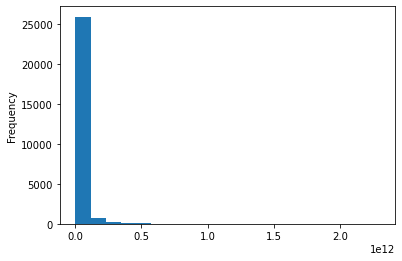

In [41]:
y.plot.hist(bins=20)

In [42]:
mask = (y > 0).values
mask

array([ True,  True,  True, ...,  True,  True,  True])

In [43]:
y_exp = np.log(list(y[mask]))
y_exp

array([23.69535911, 23.74263653, 23.71660473, ..., 22.81804382,
       22.67234514, 22.47012169])

<AxesSubplot:ylabel='Frequency'>

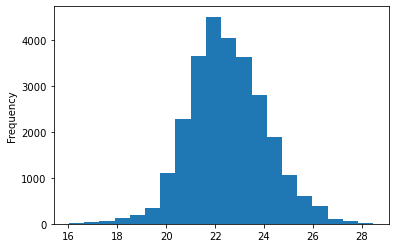

In [44]:
pd.Series(y_exp).plot.hist(bins=20)

# Train model

In [45]:
base_models = [
    LogExpModel(lgbm.sklearn.LGBMRegressor()),
    LogExpModel(XGBRegressor())
]
ensemble = EnsembleModel(base_models=base_models, bagging_fraction=0.7, models_cnt=20)

In [46]:
ensemble.fit(X, y)

KeyboardInterrupt: 

In [ ]:
import lightgbm as lgb

In [ ]:
import numpy as np

In [ ]:
train_data = lgb.Dataset('train.svm.bin')
train_data

In [ ]:
data = np.random.rand(500, 10)
data

In [ ]:
label = np.random.randint(2, size=500)  # binary target
label

In [ ]:
train_data = lgb.Dataset(data, label=label)

In [ ]:
validation_data = train_data.create_valid('validation.svm')
validation_data

In [ ]:
param = {'num_leaves': 31, 'objective': 'binary'}
param['metric'] = 'auc'
param['metric'] = ['auc', 'binary_logloss']
param

In [ ]:
num_round = 10
bst = lgb.train(param, train_data, num_round, valid_sets=[validation_data])